In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance

In [2]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [3]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date, end=end_date)

[*********************100%***********************]  15 of 15 completed


In [4]:
data['Close'].head()

AUDUSD=X  CADUSD=X  CHFUSD=X  CNYUSD=X  DKKUSD=X  EURUSD=X  \
Date                                                                     
2016-02-01  0.706864  0.715676  0.976086  0.152297  0.145087  1.082591   
2016-02-02  0.711086  0.716846  0.980873  0.152244  0.146036  1.089728   
2016-02-03  0.702988  0.711238  0.981653  0.152212  0.146354  1.092204   
2016-02-04  0.715461  0.724942  0.994827  0.152277  0.148637  1.109102   
2016-02-05  0.719942  0.726998  1.006654  0.152560  0.150071  1.119996   

            GBPUSD=X  HKDUSD=X  JPYUSD=X  KZTUSD=X  NOKUSD=X  NZDUSD=X  \
Date                                                                     
2016-02-01  1.424603  0.128481  0.008241  0.002743  0.115135  0.646998   
2016-02-02  1.442793  0.128553  0.008275  0.002805  0.115201  0.654579   
2016-02-03  1.440922  0.128317  0.008343  0.002683  0.114683  0.652018   
2016-02-04  1.458576  0.128345  0.008466  0.002762  0.116773  0.664717   
2016-02-05  1.458109  0.128403  0.008557  0.002772  0.117701  0.672993   

            PLNUSD=X  RUBUSD=X  SEKUSD=X  
Date                                      
2016-02-01  0.245228  0.013256  0.116426  
2016-02-02  0.247986  0.012943  0.117306  
2016-02-03  0.248004  0.012545  0.116964  
2016-02-04  0.251062  0.012999  0.118491  
2016-02-05  0.253291  0.013026  0.119067

In [5]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [6]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN

Using TensorFlow backend.


In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
new_data['day'] = new_data.index.day
new_data['month'] = new_data.index.month

In [9]:
values = new_data.values

In [10]:
values

array([[ 0.70686364,  0.71567619,  0.9760859 , ...,  0.11642582,
         1.        ,  2.        ],
       [ 0.71108586,  0.71684587,  0.98087299, ...,  0.11730605,
         2.        ,  2.        ],
       [ 0.70298767,  0.71123755,  0.98165292, ...,  0.1169644 ,
         3.        ,  2.        ],
       ...,
       [ 0.69247282,  0.76016724,  1.02103329, ...,  0.10641468,
        26.        , 12.        ],
       [ 0.69463742,  0.7628929 ,  1.01887989, ...,  0.10633377,
        27.        , 12.        ],
       [ 0.69829965,  0.76491195,  1.02699983, ...,  0.10722665,
        30.        , 12.        ]])

In [11]:
values.shape

(1018, 17)

In [12]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [13]:
scaled

array([[0.25593185, 0.0386939 , 0.0439291 , ..., 0.5885236 , 0.        ,
        0.09090909],
       [0.28590202, 0.04889107, 0.0861063 , ..., 0.62116647, 0.03333334,
        0.09090909],
       [0.2284193 , 0.        , 0.09297752, ..., 0.6084964 , 0.06666668,
        0.09090909],
       ...,
       [0.15378284, 0.42654943, 0.43994617, ..., 0.21726441, 0.8333334 ,
        1.        ],
       [0.16914749, 0.4503107 , 0.42097282, ..., 0.21426368, 0.8666667 ,
        1.        ],
       [0.19514275, 0.46791172, 0.4925146 , ..., 0.24737573, 0.96666664,
        1.        ]], dtype=float32)

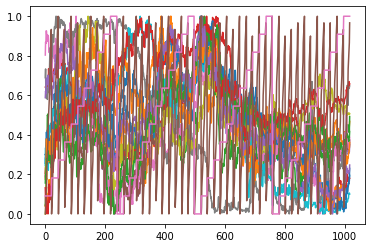

In [14]:
plt.plot(scaled)
plt.show()

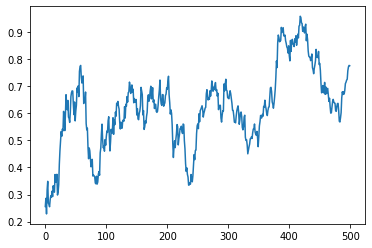

In [15]:
plt.plot(scaled[:,0][0:500])

In [16]:
# specify the number of lag hours
n_hours = 30
n_features = scaled.shape[1]
n_predict = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predict)
print(reframed.shape)

(987, 544)


In [17]:
reframed.head()

var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
30    0.255932    0.038694    0.043929    0.641567    0.187778    0.205439   
31    0.285902    0.048891    0.086106    0.638932    0.221347    0.239113   
32    0.228419    0.000000    0.092978    0.637329    0.232592    0.250793   
33    0.316959    0.119473    0.209049    0.640536    0.313314    0.330521   
34    0.348768    0.137392    0.313253    0.654541    0.363995    0.381919   

    var7(t-30)  var8(t-30)  var9(t-30)  var10(t-30)  ...  var8(t+1)  \
30    0.803655    0.689125    0.000000     0.245129  ...   0.947472   
31    0.869385    0.733315    0.019286     0.334864  ...   0.935738   
32    0.862624    0.586983    0.057711     0.157589  ...   0.943565   
33    0.926417    0.604622    0.127063     0.272308  ...   0.968369   
34    0.924726    0.640358    0.178442     0.287877  ...   0.986298   

    var9(t+1)  var10(t+1)  var11(t+1)  var12(t+1)  var13(t+1)  var14(t+1)  \
30   0.307518    0.525152    0.430639    0.343972    0.372731    0.311849   
31   0.339367    0.508194    0.380462    0.287406    0.364054    0.281301   
32   0.355022    0.500632    0.444308    0.387571    0.404894    0.327771   
33   0.418180    0.473091    0.525169    0.464190    0.451275    0.394043   
34   0.413850    0.487308    0.488729    0.415730    0.447589    0.385750   

    var15(t+1)  var16(t+1)  var17(t+1)  
30    0.714828    0.466667    0.181818  
31    0.729730    0.500000    0.181818  
32    0.775615    0.533333    0.181818  
33    0.804267    0.566667    0.181818  
34    0.779471    0.666667    0.181818  

[5 rows x 544 columns]

In [18]:
# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [19]:
# split into input and outputs
n_obs = n_hours * n_features

In [20]:
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 510) (500, 34)
(500, 30, 17) (500, 34) (487, 30, 17) (487, 34)


In [21]:
train_X[0]

array([[0.25593185, 0.0386939 , 0.0439291 , 0.64156723, 0.18777752,
        0.20543861, 0.8036547 , 0.68912506, 0.        , 0.24512935,
        0.30025148, 0.1762433 , 0.15635943, 0.1321969 , 0.5885236 ,
        0.        , 0.09090909],
       [0.28590202, 0.04889107, 0.0861063 , 0.63893175, 0.22134686,
        0.23911333, 0.86938477, 0.7333145 , 0.01928616, 0.3348639 ,
        0.30319977, 0.23539543, 0.19794154, 0.07479477, 0.62116647,
        0.03333334, 0.09090909],
       [0.2284193 , 0.        , 0.09297752, 0.6373286 , 0.23259163,
        0.25079298, 0.8626237 , 0.5869827 , 0.05771112, 0.15758896,
        0.28015852, 0.21541405, 0.19821048, 0.00151777, 0.6084964 ,
        0.06666668, 0.09090909],
       [0.3169589 , 0.1194725 , 0.20904922, 0.64053583, 0.31331444,
        0.33052063, 0.9264169 , 0.6046219 , 0.1270628 , 0.27230763,
        0.37307405, 0.31450033, 0.24432397, 0.08500123, 0.66509414,
        0.10000001, 0.09090909],
       [0.34876776, 0.13739157, 0.3132534 , 0.654541

In [22]:
train_y[0]

array([0.6069503 , 0.38614464, 0.40973663, 0.7353339 , 0.35148287,
       0.36681175, 0.8520665 , 0.9360504 , 0.30978966, 0.5302913 ,
       0.46760988, 0.38757133, 0.3826518 , 0.3251357 , 0.72002053,
       0.43333337, 0.18181819, 0.5770712 , 0.36773443, 0.37049484,
       0.7298155 , 0.3210435 , 0.33569098, 0.81666756, 0.9474716 ,
       0.30751848, 0.52515244, 0.4306388 , 0.34397173, 0.3727312 ,
       0.31184864, 0.7148278 , 0.46666667, 0.18181819], dtype=float32)

In [23]:
values[:,0][0:n_hours+n_predict]

array([0.25593185, 0.28590202, 0.2284193 , 0.3169589 , 0.34876776,
       0.26837587, 0.26339102, 0.25486803, 0.28088236, 0.2952509 ,
       0.29021263, 0.31223917, 0.2923708 , 0.33226538, 0.31369066,
       0.30861568, 0.37390852, 0.3461938 , 0.3454585 , 0.3746519 ,
       0.2981348 , 0.30861568, 0.33628893, 0.41171074, 0.46119356,
       0.49924374, 0.5324764 , 0.51516104, 0.5415735 , 0.5352416 ,
       0.6069503 , 0.5770712 ], dtype=float32)

W0512 15:01:20.570508 15336 deprecation_wrapper.py:119] From D:\Мои документы\env\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0512 15:01:20.585469 15336 deprecation_wrapper.py:119] From D:\Мои документы\env\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0512 15:01:20.587463 15336 deprecation_wrapper.py:119] From D:\Мои документы\env\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0512 15:01:20.915611 15336 deprecation_wrapper.py:119] From D:\Мои документы\env\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0512 15:01:21.145968 15336 deprecation.py:323] From D:\Мои документы\env\lib\site-packages\tens

Train on 500 samples, validate on 487 samples
Epoch 1/150
 - 1s - loss: 0.5267 - val_loss: 0.3635
Epoch 2/150
 - 0s - loss: 0.4468 - val_loss: 0.2913
Epoch 3/150
 - 0s - loss: 0.3652 - val_loss: 0.2417
Epoch 4/150
 - 0s - loss: 0.2900 - val_loss: 0.2147
Epoch 5/150
 - 0s - loss: 0.2404 - val_loss: 0.2004
Epoch 6/150
 - 0s - loss: 0.2030 - val_loss: 0.1868
Epoch 7/150
 - 0s - loss: 0.1793 - val_loss: 0.1821
Epoch 8/150
 - 0s - loss: 0.1631 - val_loss: 0.1756
Epoch 9/150
 - 0s - loss: 0.1544 - val_loss: 0.1729
Epoch 10/150
 - 0s - loss: 0.1535 - val_loss: 0.1741
Epoch 11/150
 - 0s - loss: 0.1497 - val_loss: 0.1746
Epoch 12/150
 - 0s - loss: 0.1502 - val_loss: 0.1704
Epoch 13/150
 - 0s - loss: 0.1465 - val_loss: 0.1755
Epoch 14/150
 - 0s - loss: 0.1501 - val_loss: 0.1709
Epoch 15/150
 - 0s - loss: 0.1399 - val_loss: 0.1775
Epoch 16/150
 - 0s - loss: 0.1423 - val_loss: 0.1724
Epoch 17/150
 - 0s - loss: 0.1351 - val_loss: 0.1744
Epoch 18/150
 - 0s - loss: 0.1340 - val_loss: 0.1700
Epoch 19/

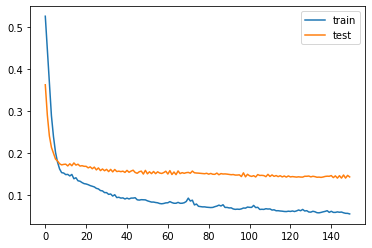

In [24]:
# design network
model = Sequential()
#model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, activation='relu'))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation = 'relu'))
model.add(GRU(50, return_sequences=False, activation='relu'))
model.add(Dense(train_y.shape[1], activation='linear'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
def predict(start_arr, dist):
    res = np.array(start_arr)[:,0:n_features]
    
    for i in range(dist):
        pred = model.predict(np.array([res[-n_hours:]])).reshape(n_predict,n_features)
        res = np.concatenate((res, pred))
        if len(res) > dist + len(start_arr):
            break
    
    return res

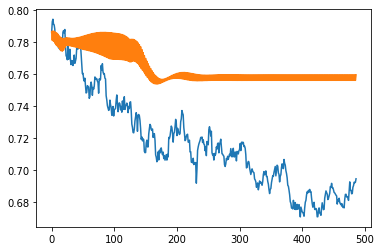

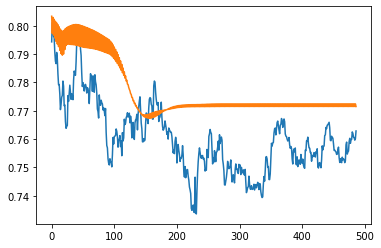

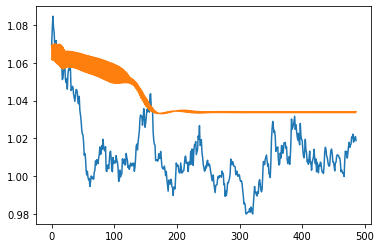

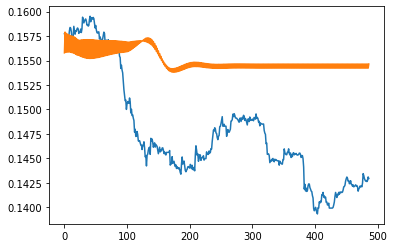

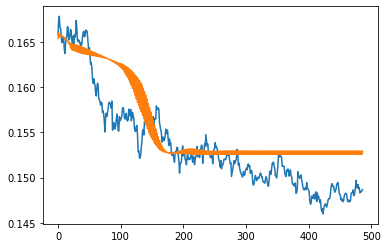

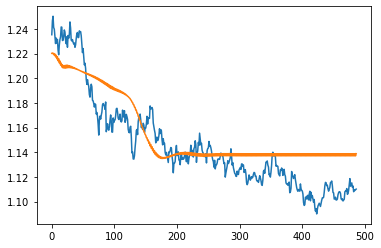

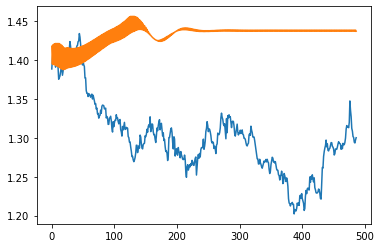

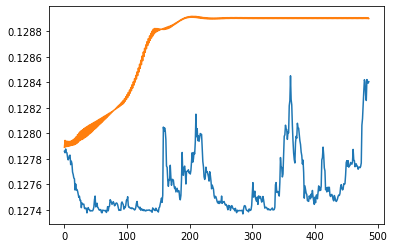

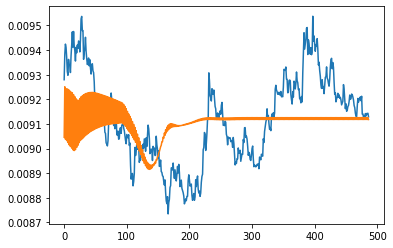

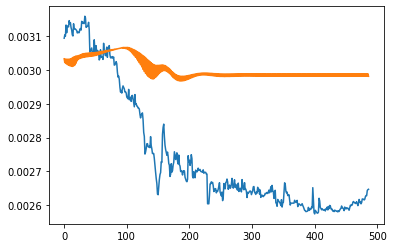

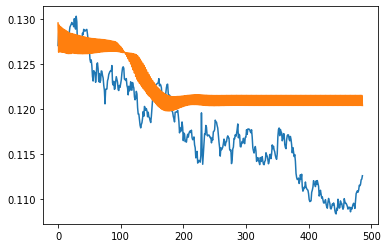

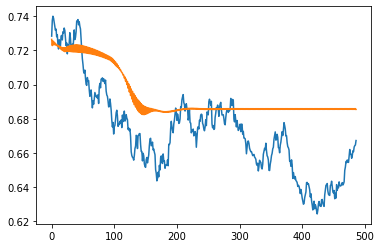

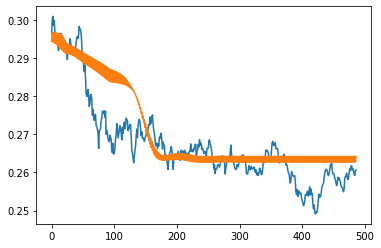

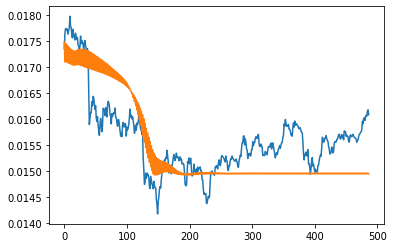

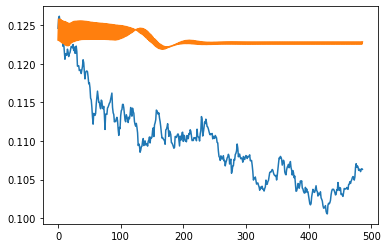

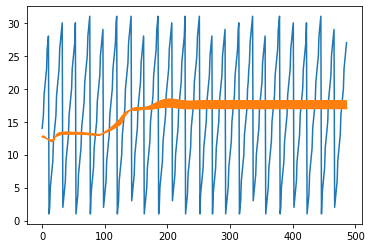

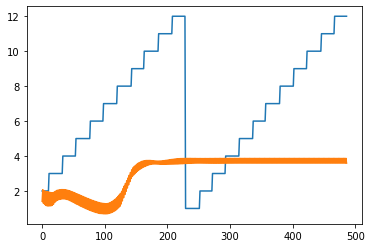

In [26]:
for i in range(n_features):
  plt.plot(scaler.inverse_transform(test_y[:,0:n_features])[:,i])
  plt.plot(scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])[:,i])
  plt.show()

In [27]:
train_y[:,0:n_features][-1]

array([0.81706524, 0.7310982 , 0.83199215, 0.92659616, 0.9002433 ,
       0.90268946, 0.6613941 , 0.32091522, 0.54248667, 0.71871114,
       0.80399084, 0.79502726, 0.9099939 , 0.8785498 , 0.8759854 ,
       0.40000004, 0.09090909], dtype=float32)

In [28]:
train_y[:,n_features:][-1]

array([0.8183813 , 0.7244911 , 0.8648176 , 0.90996313, 0.9203243 ,
       0.9262829 , 0.6739063 , 0.30369568, 0.58720064, 0.7551248 ,
       0.8320441 , 0.81038046, 0.9291289 , 0.88591385, 0.8917711 ,
       0.43333337, 0.09090909], dtype=float32)

In [29]:
test_y[:,0:n_features][0]

array([0.8183813 , 0.7244911 , 0.8648176 , 0.90996313, 0.9203243 ,
       0.9262829 , 0.6739063 , 0.30369568, 0.58720064, 0.7551248 ,
       0.8320441 , 0.81038046, 0.9291289 , 0.88591385, 0.8917711 ,
       0.43333337, 0.09090909], dtype=float32)

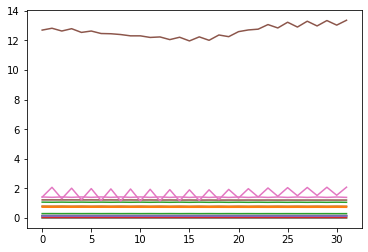

In [30]:
plt.plot(scaler.inverse_transform(predict(train_y, 30)[500:]))

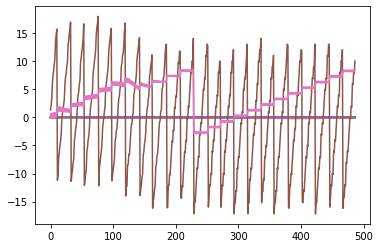

In [31]:
plt.plot(scaler.inverse_transform(test_y[:,0:n_features]) - scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)]))

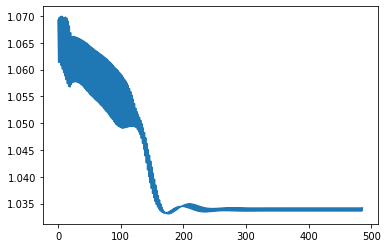

In [32]:
plt.plot(scaler.inverse_transform(predict(train_y, len(test_y)))[500:500+len(test_y),2])

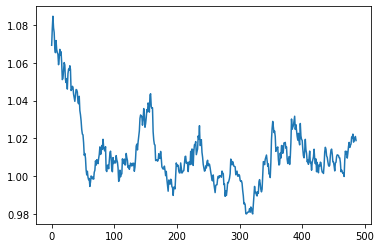

In [33]:
plt.plot(scaler.inverse_transform(test_y[:,0:n_features])[:,2])

In [33]:
predict(train_y, 10)[:500][-1]

array([0.9542732 , 0.83213663, 0.6021824 , 0.83158636, 0.8798003 ,
       0.8802781 , 0.7558255 , 0.3224945 , 0.43575668, 0.8361578 ,
       0.9218112 , 0.89123535, 0.89583516, 0.9528742 , 0.9094231 ],
      dtype=float32)

In [ ]:
test_y[0][:n_features]

In [ ]:
train_y[-1][n_features:]